In [1]:
# !pip install plotly
# !pip install matplotlib==3.5.0

In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import plotly.express as px
from difflib import SequenceMatcher
import seaborn as sns

In [2]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)

CO_IPRESS_df = pd.read_excel('web_resources/ICD10/CIE10-VOLUMEN-2018-EXCEL.xlsx', index_col=None, header=0) 
CO_IPRESS_df['DIAGNOSIS_ID'] = CO_IPRESS_df['CIE10_X'].apply(lambda x: x[:-1]+'.'+x[-1:])
CO_IPRESS_df = CO_IPRESS_df[['DIAGNOSIS_ID','DESCRIPCION CIE']]
CO_IPRESS_df = CO_IPRESS_df.rename(columns={'DESCRIPCION CIE': 'DISEASE'})
CO_IPRESS_df = CO_IPRESS_df.set_index('DIAGNOSIS_ID').T.to_dict('list')

def diagnosis_grouped(val, values_dict):
    val = str(val)
    #val = str(val)[:2]
    try:
        val = values_dict[val][0]
    except:
        val = val
    return val

In [4]:
all_data = pd.read_pickle('data_preprocessed/morbilidad_global_2018_lima.pkl')
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.2,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.4,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R11.X,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R42.X,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE


In [5]:
set(all_data['CATEGORY'])

{'0', 'I-2', 'I-3', 'I-4', 'II-1', 'II-2', 'II-E', 'III-1', 'III-2', 'III-E'}

In [6]:
diagnostics_tag = np.unique(all_data['DISEASE_GROUP'])

cmap = cm.get_cmap('tab20b', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20c', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)
# new_colors = []
# for i in range(len(colorsc)):
#     new_colors.append(colorsc[i])
#     new_colors.append(colorsb[i])

dict_colors = {}
counter = 0
for d in diagnostics_tag:
    x=colors[counter]
    dict_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

#### Lima data 

In [7]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.reset_index(drop=True)
    temp_df = temp_df.head(5).reset_index(drop=True)
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

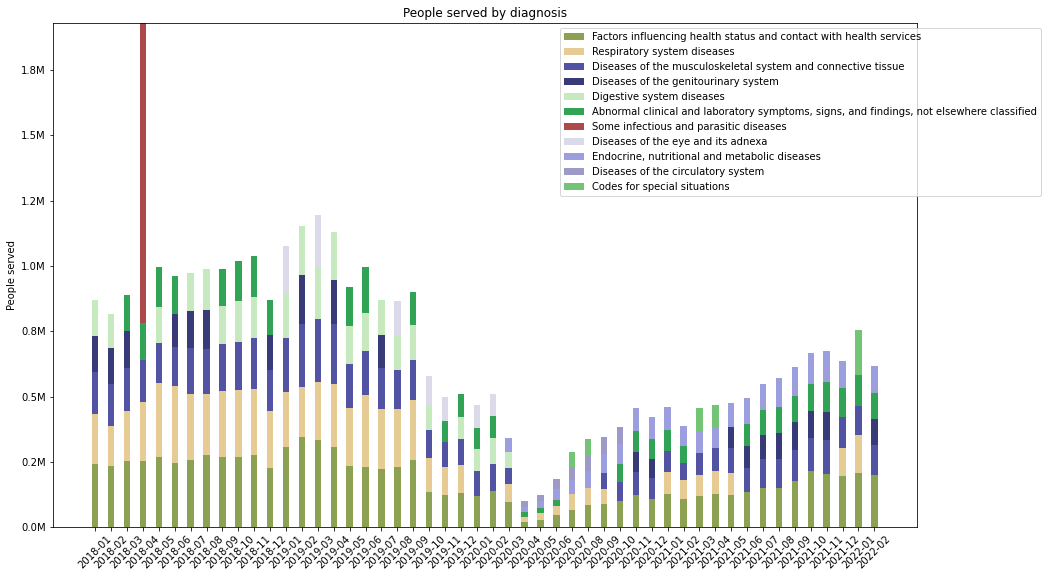

In [8]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40

fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)
ax.yaxis.set_major_formatter(millions)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

In [9]:
data_temp = all_data.groupby(['DATE','DISEASE']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DATE']).agg({ 'QTY_PEOPLE_SERVED': ['sum', 'count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'sum': 'People_served', 'count': 'Unique_diagnosis'})

### Top 10 diagnosis 

In [10]:
PARAMETER = 'DISEASE_GROUP'

data_temp = all_data.groupby(['DATE', PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

top_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    #temp_df = temp_df.head(10).reset_index(drop=True)
    temp_df = temp_df.reset_index(drop=True)
    total = sum(temp_df['QTY_PEOPLE_SERVED'])
    temp_df['PER'] = temp_df['QTY_PEOPLE_SERVED']/total*100
    top_df = pd.concat([top_df, temp_df])
    
diagnosis = top_df[PARAMETER].unique()

# For ausent dates
for date in date_uniques:
    temp_df = top_df[top_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    temp_df['PER']=0
    top_df = pd.concat([top_df, temp_df])

top_df = top_df.sort_values(by=['DATE', PARAMETER], ascending=True)

Sanity check for IHM using respiratory deseases. In IHM profile respiratory desease is 8% for Peru while in our Lima dataset we have arronf 9%


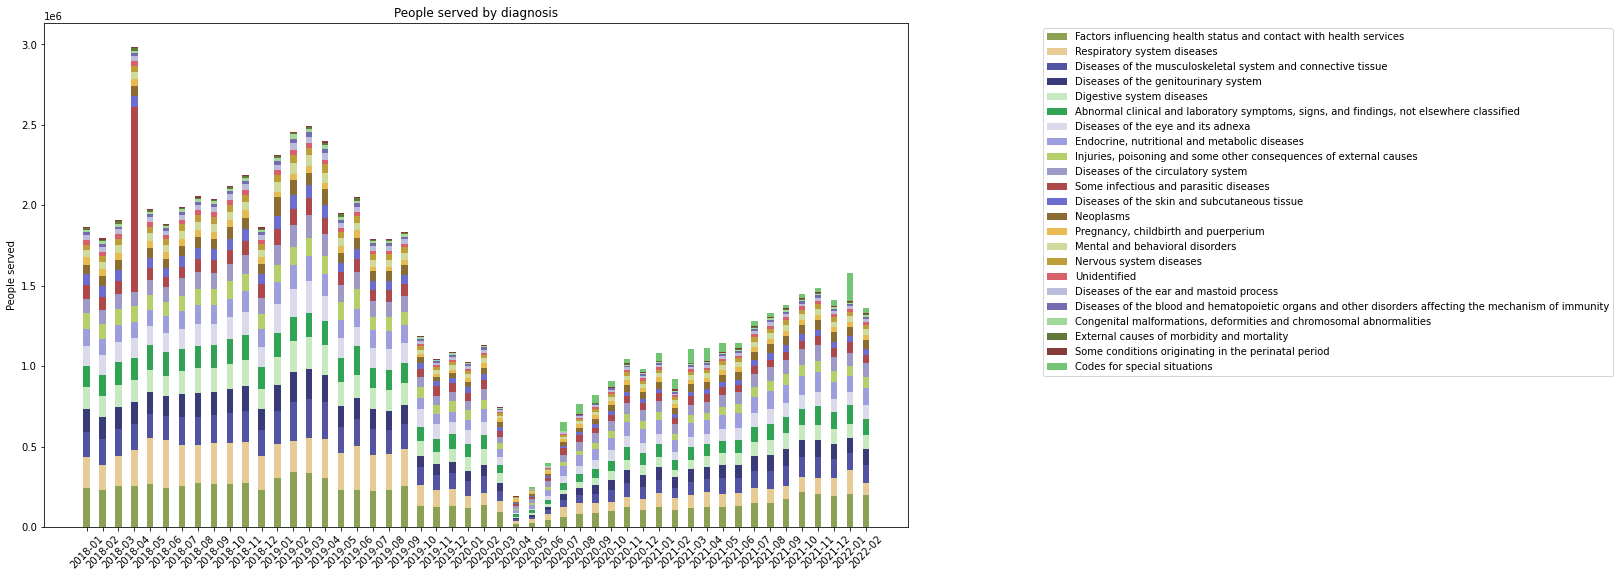

In [11]:
x_element = [str(item)[:7] for item in np.unique(top_df['DATE'])]
n = len(x_element)
ind = np.arange(n) 
width = 0.40


fig = plt.figure(figsize=(12,7))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
i = 0
for diag in diagnosis:
    temp_df = top_df[top_df[PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp, color=dict_colors[diag])
    values_temp = values_temp + values
    i+=1

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45) 

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

## Estudio por categorias y diagnosticos

In [12]:
import plotly.express as px

In [13]:
def top_of_df(data, top = 5):
    df = data.copy()
    for row in range(len(df)):
        list_values = df.loc[row, columns_name].values
        top_values = list(-np.sort(-list_values)[:top])

        for i in range(list_values.size):
            val = list_values[i]
            if val in top_values:
                df.iloc[[row],i+1] = val
            else:
                df.iloc[[row],i+1] = 0
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.replace(0,np.nan)
    return df

# CODE

In [14]:
print(set(all_data['DISEASE_GROUP']))

print()
data_temp = all_data[all_data['DISEASE_GROUP']=='Codes for special situations']
print(set(data_temp['DIAGNOSIS_ID']))

data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))
diagnostics_specials = np.unique(data_temp['DISEASE_NAME'])

cmap = cm.get_cmap('tab20c', 256)
colorsb = cmap(np.linspace(0, 1, 20))
cmap = cm.get_cmap('tab20b', 256)
colorsc = cmap(np.linspace(0, 1, 20))[8:-4]

colors = list(colorsc)+list(colorsb)

dict_special_colors = {}
counter = 0
for d in diagnostics_specials:
    x=colors[counter]
    dict_special_colors[d]=matplotlib.colors.rgb2hex(x)
    counter+=1

{'Abnormal clinical and laboratory symptoms, signs, and findings, not elsewhere classified', 'Diseases of the skin and subcutaneous tissue', 'Unidentified', 'Injuries, poisoning and some other consequences of external causes', 'Pregnancy, childbirth and puerperium', 'Diseases of the genitourinary system', 'Some infectious and parasitic diseases', 'Codes for special situations', 'Some conditions originating in the perinatal period', 'Neoplasms', 'Diseases of the ear and mastoid process', 'Endocrine, nutritional and metabolic diseases', 'Diseases of the blood and hematopoietic organs and other disorders affecting the mechanism of immunity', 'Nervous system diseases', 'External causes of morbidity and mortality', 'Diseases of the eye and its adnexa', 'Digestive system diseases', 'Diseases of the circulatory system', 'Congenital malformations, deformities and chromosomal abnormalities', 'Diseases of the musculoskeletal system and connective tissue', 'Respiratory system diseases', 'Factors 

C:\Users\johnk\AppData\Local\Temp/ipykernel_8840/3892249879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))


In [15]:
set(all_data['CATEGORY2'])

{'0', 'I', 'II', 'III'}

In [16]:
CATEGORIA_STUDIO = 'III'

### Private & Public 

In [17]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.2,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.4,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R11.X,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R42.X,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE


In [37]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = data_temp.pivot_table(index=['DATE'], 
                                  columns=['SECTOR'], 
                                  values='QTY_PEOPLE_SERVED').fillna(0)
data_temp = data_temp.reset_index()

In [38]:
df = data_temp
columns_name = list(df.columns)[1:]
fig = px.line(df, 
              x="DATE", 
              y=columns_name,
              hover_data={"DATE": "|%Y %M"},
              labels={
                     "value": "People served (qty)",
                     "DATE": "Date",
                     "variable": "Sector"
                 },
              title='Total people served to Category ' + CATEGORIA_STUDIO)

# fig = px.scatter(data_temp, x="DATE", y=data_temp.columns,
#               hover_data={"DATE": "|%Y %M"},
#               labels={
#                      "value": "People served (qty)",
#                      "DATE": "Date",
#                      "SECTOR2": "Sector"
#                  },
#               title='Total people served to Category ' + CATEGORIA_STUDIO)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b-%Y")
fig.show()

In [39]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

In [40]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="QTY_PEOPLE_SERVED", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO,
            )
        
fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_"+CATEGORIA_STUDIO+".html")

### Normalized by Hospital and People (qty)

In [41]:
data_temp.head()

,DATE,SECTOR,DISEASE_GROUP,QTY_PEOPLE_SERVED
0,2018-01-01,PRIVATE,"Abnormal clinical and laboratory symptoms, sig...",7067
1,2018-01-01,PRIVATE,"Congenital malformations, deformities and chro...",480
2,2018-01-01,PRIVATE,Digestive system diseases,5394
3,2018-01-01,PRIVATE,Diseases of the blood and hematopoietic organs...,953
4,2018-01-01,PRIVATE,Diseases of the circulatory system,5441


In [42]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]


data_hosp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_hosp = data_hosp.reset_index()
data_hosp =  data_hosp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': "count"})
data_hosp = data_hosp.reset_index()

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_GROUP']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_pers =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_pers = data_pers.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = pd.merge(data_temp, data_hosp, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_HOSPITAL'] = data_temp['QTY_PEOPLE_SERVED']/data_temp['CO_IPRESS']


data_temp = pd.merge(data_temp, data_pers, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_PEOPLE'] = data_temp['QTY_PEOPLE_SERVED_x']/data_temp['QTY_PEOPLE_SERVED_y']


#### Graph to Normalized by hospital

In [23]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMALIZED_HOSPITAL", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by hospital)',
            )

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_Hospitals_Cat-"+CATEGORIA_STUDIO+"_bar.html")

In [24]:
fig = px.line(data_temp, 
                 x="DATE", 
                 y="NORMALIZED_HOSPITAL", 
                 color="DISEASE_GROUP", 
                 facet_col="SECTOR",
                 width=1000, height=1000,
                 color_discrete_map = dict_colors,
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by hospital)',
             )

fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_Hospitals_Cat-"+CATEGORIA_STUDIO+"_line.html")

#### Graph to Normalized by people

In [25]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMALIZED_PEOPLE", 
             color="DISEASE_GROUP", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1000, height=1000,
             color_discrete_map = dict_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)',
            )


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_bar.html")

In [26]:
fig = px.line(data_temp, 
                 x="DATE", 
                 y="NORMALIZED_PEOPLE", 
                 color="DISEASE_GROUP", 
                 facet_col="SECTOR",
                 width=1000, height=1000,
                 color_discrete_map = dict_colors,
                 title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)'
             )


fig.update_layout(legend=dict(yanchor="top",
                              y=-0.1,
                              xanchor="left",
                              x=0
                             ),
                  showlegend=True
                 )

fig.show()
fig.write_html("figures/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_line.html")

#### Number of hopital

In [27]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': ['sum','count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': ['count']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()

data_temp = data_temp.rename(columns={'count':'Hospitals Qty',})

In [28]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="Hospitals Qty", 
             color="SECTOR", 
             barmode="group", 
             width=1000, height=500,
             title='Number of Hospitals for Category ' + CATEGORIA_STUDIO,
            )     
fig.show()
#fig.write_html("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_bars.html")
fig.write_image("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_bars.png", format  = 'png')

In [29]:
fig = px.line(data_temp, 
             x="DATE", 
             y="Hospitals Qty", 
             color="SECTOR",
             width=1000, height=500,
             title='Number of Hospitals for Category ' + CATEGORIA_STUDIO,
            )     
fig.show()
#fig.write_html("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_lines.html")
fig.write_image("figures/hospital_qty/category_"+CATEGORIA_STUDIO+"_lines.png", format  = 'png')

#### Focus on Special codes

In [30]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp[data_temp['DISEASE_GROUP']=='Codes for special situations']
data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))

data_temp =  data_temp.groupby(['DATE', 'SECTOR','DISEASE_NAME']).agg({ 'QTY_PEOPLE_SERVED': ['sum']})
data_temp.columns = data_temp.columns.droplevel()
data_temp = data_temp.reset_index()
data_temp = data_temp.rename(columns={'sum':'QTY_PEOPLE_SERVED',})

fig = px.bar(data_temp, 
             x="DATE", 
             y="QTY_PEOPLE_SERVED", 
             color="DISEASE_NAME", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1700, height=800,
             color_discrete_map = dict_special_colors,
             title='Special Codes to Category ' + CATEGORIA_STUDIO,             
            )


fig.show()
#fig.write_html("figures/special_codes/SpecialCodes_Sector_"+CATEGORIA_STUDIO+".html")
fig.write_image("figures/special_codes/SpecialCodes_Sector_"+CATEGORIA_STUDIO+".png", format  = 'png')

In [31]:
data_temp = all_data[all_data['CATEGORY2']==CATEGORIA_STUDIO]
data_temp = data_temp[data_temp['DISEASE_GROUP']=='Codes for special situations']

data_hosp =  data_temp.groupby(['DATE', 'SECTOR', 'CO_IPRESS']).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_hosp = data_hosp.reset_index()
data_hosp =  data_hosp.groupby(['DATE', 'SECTOR']).agg({ 'CO_IPRESS': "count"})
data_hosp = data_hosp.reset_index()

data_temp['DISEASE_NAME'] = data_temp['DIAGNOSIS_ID'].apply(lambda x : diagnosis_grouped(x, CO_IPRESS_df))

data_temp =  data_temp.groupby(['DATE', 'SECTOR', 'DISEASE_NAME']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()

data_pers =  data_temp.groupby(['DATE', 'SECTOR']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_pers = data_pers.reset_index()

#data_temp['QTY_PEOPLE_SERVED'] =data_temp['QTY_PEOPLE_SERVED'].mask((data_temp['DATE'].dt.year==2018) & (data_temp['DATE'].dt.month==4),0)

data_temp = pd.merge(data_temp, data_hosp, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_HOSPITAL'] = data_temp['QTY_PEOPLE_SERVED']/data_temp['CO_IPRESS']


data_temp = pd.merge(data_temp, data_pers, how='inner', on=('DATE','SECTOR'))
data_temp['NORMALIZED_PEOPLE'] = data_temp['QTY_PEOPLE_SERVED_x']/data_temp['QTY_PEOPLE_SERVED_y']

#### Normalized by people special codes

In [32]:
fig = px.bar(data_temp, 
             x="DATE", 
             y="NORMALIZED_PEOPLE", 
             color="DISEASE_NAME", 
             barmode="stack", 
             facet_col="SECTOR",
             width=1500, height=600,
             color_discrete_map = dict_special_colors,
             title='Total people served to Category ' + CATEGORIA_STUDIO + ' (Normalized by people)',
            )


fig.show()
#ig.write_html("figures/special_codes/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_bar.html")
fig.write_image("figures/special_codes/Sector_Normalized_People_Cat-"+CATEGORIA_STUDIO+"_bar.png", format  = 'png')

# ------------------------------------------------

In [33]:
###

In [34]:
# all_data = all_data[(all_data['YEAR']>=2018) & (all_data['YEAR']<2022)]
# np.unique(all_data.DATE)

In [35]:
all_data.head()

,DATE,YEAR,MONTH,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CATEGORY2,CO_IPRESS,...,DIAGNOSIS_ID,QTY_PEOPLE_SERVED,DISEASE,DISEASE_GROUP,COD_IPRESS,x,y,SECTOR_R,TYPE,SECTOR2
0,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.2,10,PELVIC AND PERINEAL PAIN,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
1,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R10.4,11,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
2,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R11.X,3,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
3,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R16.0,1,"HEPATOMEGALY, NOT ELSEWHERE CLASSIFIED","Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE
4,2018-01-01,2018,1,LIMA,LIMA,LIMA,PRIVATE,II-2,II,00015610,...,R42.X,1,UNIDENTIFIED,"Abnormal clinical and laboratory symptoms, sig...",00015610,-12.058367,-77.038362,PRIVADO,Outpatient Consultation,PRIVATE


# 